# End to End XGBoost

https://github.com/mattharrison/2022-odsc-xgboost

©2023 MetaSnake

`@__mharrison__`

In [91]:
import xgboost
xgboost.__version__

'1.7.2'

## Libraries
We will also use SHAP, xgbfir, openpyxl, hyperopt

In [ ]:
# for colab
!pip install dtreeviz feature_engine pybaobabdt xgbfir shap

In [92]:
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

## Datasets

I'll be demoing with Kaggle 2018 survey data


In [101]:
import os
local = 'kaggle-survey-2018.zip'
if not os.path.exists(local):
    url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(local, mode='wb') as fout:
        fout.write(data)
with zipfile.ZipFile(local) as z:
    print(z.namelist())
    kag = pd.read_csv(z.open('multipleChoiceResponses.csv'))
    kag_questions = kag.iloc[0]
    raw = kag.iloc[1:]

['multipleChoiceResponses.csv', 'freeFormResponses.csv', 'SurveySchema.csv']


Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


In [102]:
def topn(ser, n=5, default='other'):
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

def tweak_kag(df):
    return (df
        #.query('Q3.isin(["United States of America", "China", "India"]) '\
        #       'and Q6.isin(["Data Scientist", "Software Engineer"])')
        .loc[df.Q3.isin(["United States of America", "China", "India"]) &
             df.Q6.isin(["Data Scientist", "Software Engineer"])]
        .pipe(lambda df_:
            df_.assign(**(df_.Q1.pipe(pd.get_dummies, drop_first=True, prefix='gender')),
                       age=df_.Q2.str.slice(0,2).astype(int),
                       **(df_.Q3.pipe(pd.get_dummies, drop_first=True, prefix='country')),
                       education=df_.Q4.replace({'Master’s degree': 18,
                         'Bachelor’s degree': 16,
                         'Doctoral degree': 20,
                         'Some college/university study without earning a bachelor’s degree': 13,
                         'Professional degree': 19,
                         'I prefer not to answer': None,
                         'No formal education past high school': 12}),
                       **(df_.Q5
                              .pipe(topn, n=3)
                              .replace({
                        'Computer science (software engineering, etc.)': 'cs',
                        'Engineering (non-computer focused)': 'eng',
                        'Mathematics or statistics': 'stat'})
                              .pipe(pd.get_dummies, drop_first=True, prefix='major')),
                       title=df_.Q6,
                       years_exp=(df_.Q8.str.replace('+','', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .astype(float)),
                       compensation=(df_.Q9.str.replace('+','', regex=False)
                           .str.replace(',','', regex=False)
                           .str.replace('500000', '500', regex=False)
                           .str.replace('I do not wish to disclose my approximate yearly compensation', '0', regex=False)
                           .str.split('-', expand=True)
                           .iloc[:,0]
                           .fillna(0)
                           .astype(int)
                           .mul(1_000)
                                    ),
                       python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                       r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                       sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
               )#assign
              
        )#pipe
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'gender_Male':]   
        .dropna()
       )
kag = tweak_kag(raw)
kag_X = kag.drop(columns='title')
kag_y = (kag.title == 'Data Scientist')
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, stratify=kag_y, random_state=42)

In [103]:
kag

,gender_Male,gender_Prefer_not_to_say,gender_Prefer_to_self-describe,age,country_India,country_United_States_of_America,education,major_eng,major_other,major_stat,title,years_exp,compensation,python,r,sql
3,0,0,0,30,0,1,18.0,0,0,0,Data Scientist,0.0,0,0,1,0
12,1,0,0,40,0,1,18.0,1,0,0,Data Scientist,5.0,125000,1,0,1
37,1,0,0,40,1,0,16.0,1,0,0,Software Engineer,10.0,0,1,1,0
41,1,0,0,40,0,1,20.0,0,0,0,Software Engineer,10.0,400000,1,0,0
52,1,0,0,18,1,0,16.0,0,0,0,Data Scientist,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23673,1,0,0,25,1,0,16.0,0,0,0,Software Engineer,3.0,90000,0,0,0
23684,1,0,0,18,1,0,18.0,0,0,0,Software Engineer,0.0,0,0,0,0
23712,0,0,0,25,1,0,18.0,0,0,0,Software Engineer,3.0,0,1,0,1
23796,1,0,0,22,1,0,18.0,1,0,0,Software Engineer,1.0,0,0,0,0


In [104]:
kag_y

3         True
12        True
37       False
41       False
52        True
         ...  
23673    False
23684    False
23712    False
23796    False
23813     True
Name: title, Length: 2884, dtype: bool

## Stumps, Trees, and Forests

Decision trees use a greedy algorithm to split on a feature (column) that results in the most "pure" split.

In [105]:
# True - DS
kag_y.value_counts()

True     1574
False    1310
Name: title, dtype: int64

In [106]:
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(kag_X_train, kag_y_train)
stump.score(kag_X_test, kag_y_test)

0.636615811373093

In [107]:
# False - SE, Data Scientist - DS
stump.classes_

array([0., 1.])

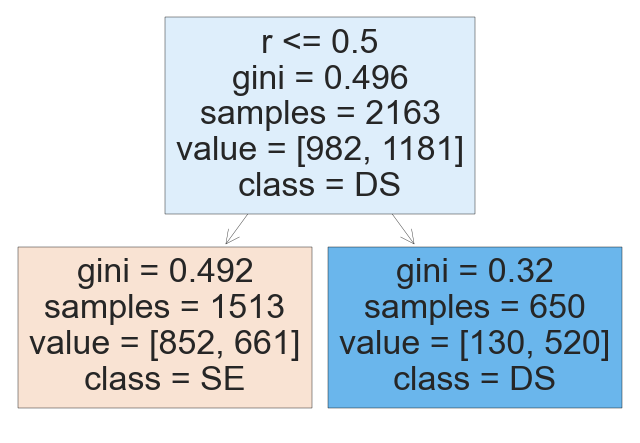

In [108]:
features = list(c for c in kag_X_train.columns)
_ = tree.plot_tree(stump, feature_names=features, filled=True, 
                   class_names=['SE', 'DS'])

## Underfit
A stump is too simple. It has too much *bias*.

Solutions:

* Add more features
* Use a more complex model

For a tree we can let it grow deeper which should do both.

## Overfitting

A model is too complicated. It has too much variance.

Solutions:

* Simplify or constrain (*regularize*)
* Add more samples

For a tree we can prune back the growth so that the leaf nodes are overly specific.

In [109]:
hi_variance = tree.DecisionTreeClassifier(max_depth=None)
hi_variance.fit(kag_X_train, kag_y_train)
hi_variance.score(kag_X_test, kag_y_test)

0.6310679611650486

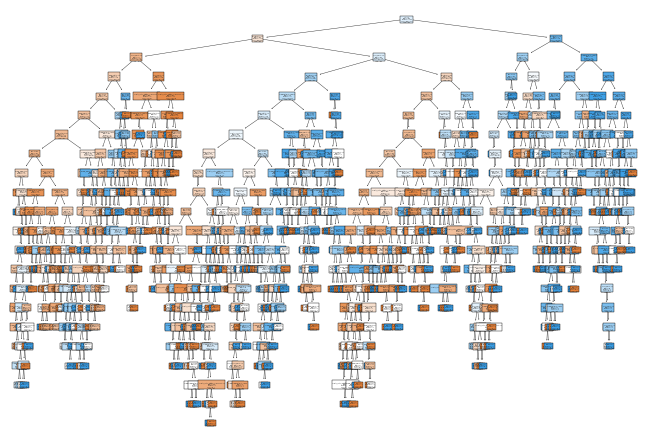

In [110]:
features = list(c for c in kag_X_train.columns)
_ = tree.plot_tree(hi_variance, feature_names=features, filled=True, 
                   class_names=['SE', 'DS'])

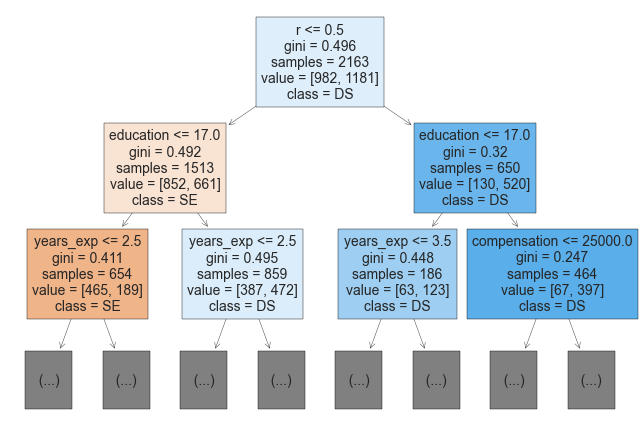

In [111]:
# limit view to first 2
features = list(c for c in kag_X_train.columns)
_ = tree.plot_tree(hi_variance, feature_names=features, filled=True, 
                   class_names=['SE', 'DS'], max_depth=2, fontsize=10)


## Tree Hyperparameters

*max_\** parameters - Raise to make more complex (overfit|more variance), lower to simplify (underfit|more bias)

*min_\** parameters - Lower to make more complex (overfit|more variance), raise to simplify (underfit|more bias)

* 'max_depth=None' - Tree depth
* 'max_features=None' - Amount of features to examine for split
* 'max_leaf_nodes=None' - Number of leafs
* 'min_impurity_decrease=0' - Split when *impurity* is >= this value. (*Impurity* : 0 - 100% accurate, .3 - 70%. Going from 70% to 100% accurate is a decrease of .3) 
* 'min_samples_leaf=1', - Minimum samples at each leaf.
* 'min_samples_split=2' - Minimum samples required to split a node.
* 'min_weight_fraction_leaf=0' - The fraction fo the total weights required to be a leaf.


In [112]:
stump.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## Random Forest

Uses *bagging* to ensemble many trees in an attempt to lower variance.

In [113]:
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(kag_X_train, kag_y_train)
rf.score(kag_X_test, kag_y_test)

0.6726768377253814

In [114]:
len(rf.estimators_)

100

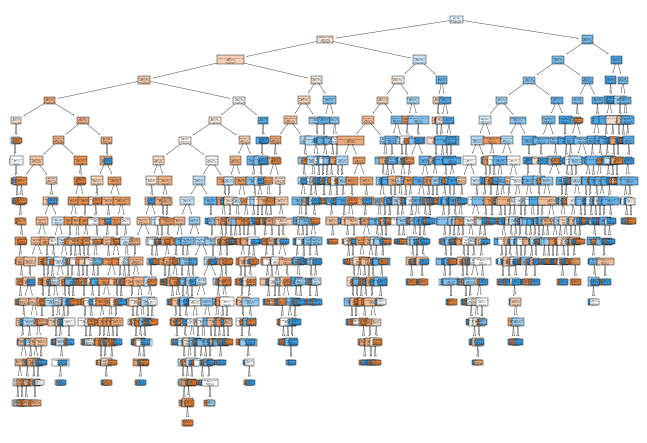

In [115]:
features = list(c for c in kag_X_train.columns)
_ = tree.plot_tree(rf.estimators_[0], feature_names=features, filled=True, 
                   class_names=['SE', 'DS'])

## Random Forest Hyperparameters

*max_\** parameters - Raise to make more complex (overfit|more variance), lower to simplify (underfit|more bias)

*min_\** parameters - Lower to make more complex (overfit|more variance), raise to simplify (underfit|more bias)

* 'n_estimators=100' - Number of trees - should be *max_estimators*
* 'oob_score=False' - Can estimate score when training (by using rows that weren't randomly selected). No need to hold out data
* 'warm_start=False' - Can add more trees w/o starting over

From tree:

* 'max_depth=None' - Tree depth (1 to Infinity (`None`))
* 'max_features="sqrt"' - Amount of features to examine for split (1 to number of features (int). Float of percent (0. to 1.0). "log2" log2(n_features) or "sqrt"  sqrt(n_features). (Default square root number of features.)
* 'max_leaf_nodes=None' - Number of leafs. Default (`None`) is unlimited.
* 'min_impurity_decrease=0' - Split when *impurity* is >= this value. (0.0 to 1.0) (*Impurity* : 0 - 100% accurate, .3 - 70%) 
* 'min_samples_leaf=1', - Minimum samples at each leaf. (1 to n_samples).
* 'min_samples_split=2' - Minimum samples required to split a node. (1 to n_samples)
* 'min_weight_fraction_leaf=0' - The fraction (0.0 to 1.0) of the total weights required to be a leaf.

In [116]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

<AxesSubplot: >

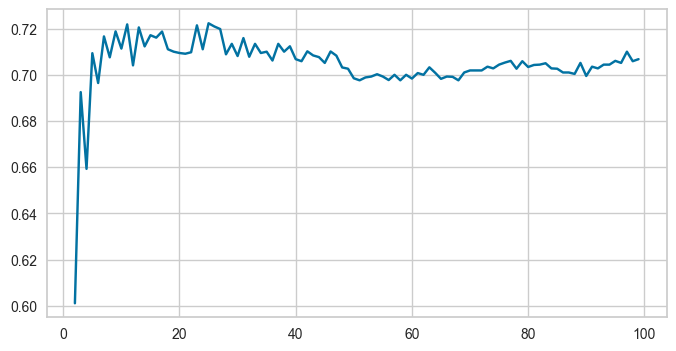

In [117]:
# visualize how changing n_estimators affects score
results = []
rf_ws = ensemble.RandomForestClassifier(random_state=42, warm_start=True, n_estimators=1)
rf_ws.fit(kag_X_train, kag_y_train)
for i in range(2,100):
    rf_ws.set_params(n_estimators=i)
    rf_ws.fit(kag_X_train, kag_y_train)
    # see other metrics
    results.append(metrics.f1_score(kag_y_test, rf_ws.predict(kag_X_test)))
pd.Series(results, index=range(2, 100)).plot(figsize=(8,4))    

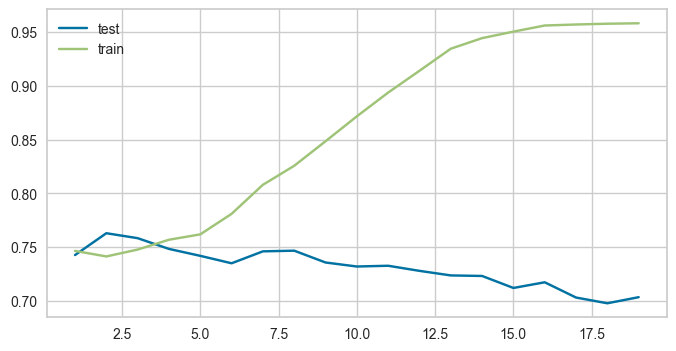

In [118]:
# visualize how changing max_depth affects score
results = []
train_results = []
vals = list(range(1,20))
for i in vals:
    rf_ws = ensemble.RandomForestClassifier(random_state=42, 
                                            max_depth=i)
    rf_ws.fit(kag_X_train, kag_y_train)
    results.append(metrics.f1_score(kag_y_test, rf_ws.predict(kag_X_test)))
    train_results.append(metrics.f1_score(kag_y_train, rf_ws.predict(kag_X_train)))
ax = pd.Series(results, index=vals, name='test').plot(figsize=(8,4))    
pd.Series(train_results, index=vals, name='train').plot(ax=ax)
ax.legend()

## XGBoost

Uses *boosting* to train a series of (weak) trees that try to correct the error of the previous output. (For classification this is mapped to a probability)

Like golfing (you continue to putt or use a different club depending on first error). Decision tree would be a single tee off. Random forest would be averaging the tee offs. 

* Regularization
* Parallel Processing
* Missing Number Support
* Category Support

In [119]:
xg = xgb.XGBClassifier()
xg.fit(kag_X_train, kag_y_train)
xg.score(kag_X_test, kag_y_test)

0.7059639389736477

In [120]:
# Let's try w/ depth of 2 and 2 trees
xg = xgb.XGBClassifier(max_depth=2, n_estimators=2)
xg.fit(kag_X_train, kag_y_train)
xg.score(kag_X_test, kag_y_test)

0.6546463245492372

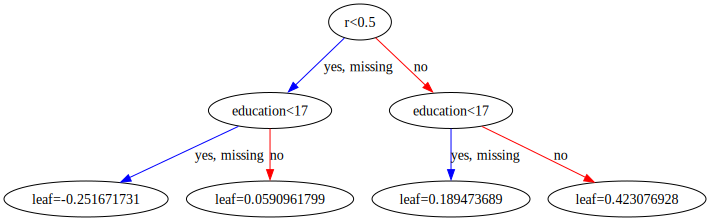

In [124]:
# first tree
# leaf values are log probabilities (*logit*)
xgb.to_graphviz(xg, size='1,1', num_trees=0, fontsize='1')

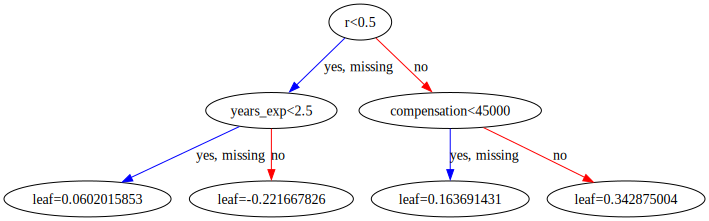

In [122]:
# second tree
xgb.to_graphviz(xg, size='1,1', num_trees=1, fontsize='1')

In [ ]:
# let's go down the left path with
# this data
row = pd.Series({'gender_Male': 0.0, 'gender_Prefer_not_to_say': 0.0, 
    'gender_Prefer_to_self-describe': 0.0, 'age': 30.0, 'country_India': 0.0, 
    'country_United_States_of_America': 1.0, 'education': 16.0, 'major_eng': 0.0, 
    'major_other': 0.0, 'major_stat': 0.0, 'years_exp': 0.0, 'compensation': 0.0, 
    'python': 0.0, 'r': 0.0, 'sql': 0.0}).to_frame().T
row

In [125]:
# result for DS = .4522
# < .5 ... so Software Engineer!
# this is [prob SE, prob DS]
xg.predict_proba(row)

array([[0.5477218, 0.4522782]], dtype=float32)

In [126]:
xg.predict(row)

array([0])

(-0.19, 0.45)


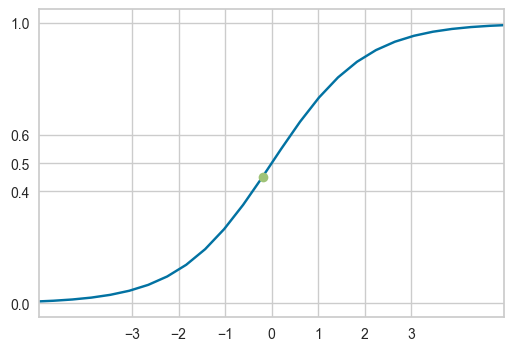

In [127]:
# sum up leafs and throw into 
# Example: no r, low ed, low exp
# -.251 + 0.0602

vals = np.linspace(-10, 10)
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

x = -.251 + 0.0602
y = inv_logit(-.251 + 0.0602)
print(f'({x:.2}, {y:.2})')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(vals, inv_logit(vals))
ax.plot([x], [y], marker='o')
ax.set_xlim([-5, 5])
_ = ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
_ = ax.set_yticks([0,.4, .5, .6, 1])

## Early Stopping
Because you can keep "putting" you can keep track of how far away you are from the hole and stop when you are closest.

In [128]:
# defaults
# 100 putts
xg = xgb.XGBClassifier()
xg.fit(kag_X_train, kag_y_train)
xg.score(kag_X_test, kag_y_test)

0.7059639389736477

In [130]:
# Early stopping
# Go up to 100 but stop after you haven't improved for 20 hits
# Min value at round 9

xg = xgb.XGBClassifier(early_stopping_rounds=20)
xg.fit(kag_X_train, kag_y_train,
       eval_set=[(kag_X_train, kag_y_train),
                 (kag_X_test, kag_y_test)], verbose=10)
xg.score(kag_X_test, kag_y_test)

[0]	validation_0-logloss:0.61287	validation_1-logloss:0.63854
[10]	validation_0-logloss:0.42605	validation_1-logloss:0.56814
[20]	validation_0-logloss:0.37680	validation_1-logloss:0.57721
[29]	validation_0-logloss:0.35135	validation_1-logloss:0.58779


0.7073509015256588

In [131]:
xg.best_ntree_limit

10

In [132]:
# we can get the evaluation metrics
# validation_0 is for training data
# validation_1 is for testing data
results = xg.evals_result()
results

{'validation_0': OrderedDict([('logloss',
               [0.6128703226687122,
                0.5664962038253117,
                0.536741612709015,
                0.5121252953565292,
                0.4931373162865914,
                0.4789114456539401,
                0.46618005515550276,
                0.45296968104101637,
                0.44390901468153415,
                0.43568846329674643,
                0.42605378247463366,
                0.41906882646238286,
                0.411986322467264,
                0.40614206003566833,
                0.4015500623874032,
                0.39579971537245434,
                0.3904026970710783,
                0.38783914319416524,
                0.3842907148114975,
                0.3799263905838022,
                0.3768039204413179,
                0.37048196496973285,
                0.367009250190965,
                0.36427683282666806,
                0.3617178381636387,
                0.35910330097726234,
             

Text(0.5, 0, 'ntrees')

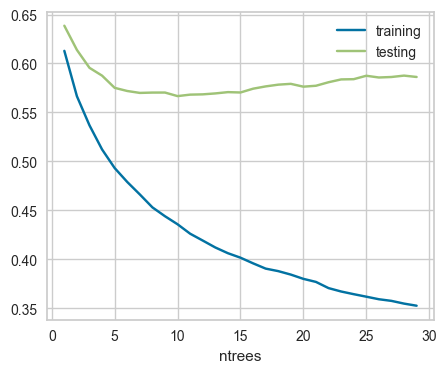

In [133]:
# Testing score is best at 11 trees
results = xg.evals_result()
ax = pd.DataFrame({'training': results['validation_0']['logloss'],
              'testing': results['validation_1']['logloss'],
             }).shift().plot(figsize=(5,4))
ax.set_xlabel('ntrees')

## XGBoost Hyperparameters

*max_\** parameters - Raise to make more complex (overfit|more variance), lower to simplify (underfit|more bias)

*min_\** parameters - Lower to make more complex (overfit|more variance), raise to simplify (underfit|more bias)

* Boosting

  * ``n_estimators=100`` - number of trees (or boosting rounds). Larger is more complex. Default 100. Use ``early_stopping_rounds`` with ``.fit`` to prevent overfitting.

  * ``learning_rate=.3`` (called ``eta`` too) - after each boosting step, shrink feature weights. Larger is more conservative. Can be used with n_estimators to adjust time for convergence [0,1], default .3

  * ``gamma=0`` / ``min_split_loss`` - L0 regularization. Global regularization. Minimum loss required for split. Larger is more conservative. [0, ∞], default 0 - No regularization.


* Regularization

  * ``reg_lambda=1`` - L2 regularization (Root of squared weights). Increase to be more conservative. Default 1
  * ``reg_alpha=0`` - L1 regularization (Mean of weights). Increase to be more conservative. Default 0

* Sampling - Use different rows

  * ``subsample=1`` - Use % of samples (this is rows!) for next boosting round. Lower to more conservative. [0, 1], default 1. (When not equal to 1.0, model does *stochastic gradient descent*, ie. there is some randomness in the model.)


New tree (sampling) parameters - Use different columns (not rows!):

  * ``colsample_bytree=1`` - Fraction of columns for each boosting round.
  
  * ``colsample_bylevel=1`` - Fraction of columns for each depth level.
  
  * ``colsample_bynode=1`` - Fraction of columns for each node.
  

From tree:

  * ``max_depth=6`` - depth of tree. Larger is more complex (more likely to overfit). How many feature interactions you can have. Each level doubles time. [0, ∞], default 6
  * ``min_child_weight=1`` - Stop splitting after certain amount of purity. Larger will be more conservative.


Imbalanced data:

* ``scale_pos_weight=1`` -  ratio negative/positive. Default 1
* Use ``'auc'`` or ``'aucpr'`` for ``eval_metric`` metric (rather than classification default ``'logless'``)
* ``max_delta_step=0`` - try values from 1-10. Default 0





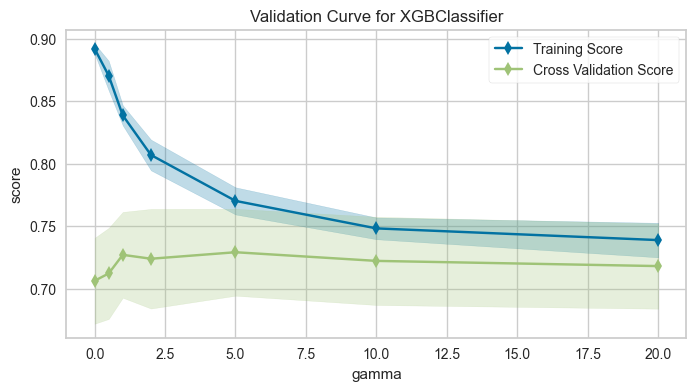

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='gamma', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gp...
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...),
                param_name='gamma',
                param_range=array([ 0. ,  0.5,  1. ,  2. ,  5. , 10. , 20. ]))

In [134]:
# try gamma on xgb
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X, kag_y,
                    param_name='gamma', param_range=[0, .5, 1,2,5,10, 20])

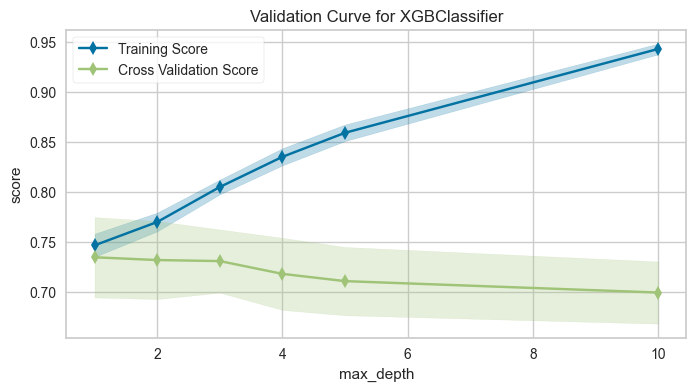

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='max_depth', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=Non...
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...),
                param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5, 10]))

In [135]:
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X, kag_y,
                    param_name='max_depth', param_range=[1,2,3,4,5,10])

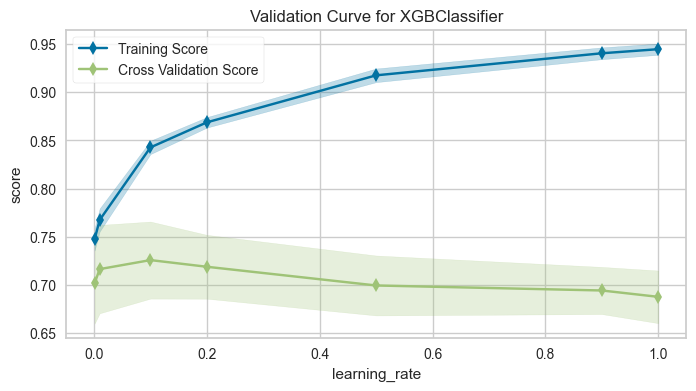

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]))

In [136]:
# note this depends on n_estimators
# should really use early stopping but yellowbrick doesn't support this 😢
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X, kag_y,
                    param_name='learning_rate', param_range=[0.001, .01, .1, .2, .5, .9, 1])

In [137]:
params = {'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

In [139]:
# this takes a while to run (about 2 minutes)
# can set scoring in GridSearchCV to 
# recall, precision, f1, accuracy
params = {'reg_lambda': [0],  # No effect
          'learning_rate': [.1, .3], # makes each boost more conservative (0 - no shrinkage) 
          #'colsample_bylevel': [.3, 1], # use 0, 50%, or 100% of columns in boost step
          'subsample': [.7, 1],
          #'gamma': [0, 1],
          'max_depth': [1, 2, 3],
          'random_state': [42],
          'n_jobs': [-1],
          #'early_stopping_rounds':[10],
          'n_estimators': [200]}
kag_xgb2 = xgb.XGBClassifier()
cv = (model_selection.GridSearchCV(kag_xgb2, params, cv=3)#, n_jobs=-1)
    .fit(kag_X_train, kag_y_train,
         eval_set=[(kag_X_test, kag_y_test)],
         early_stopping_rounds=5, verbose=10) 
     )

[0]	validation_0-logloss:0.68169
[10]	validation_0-logloss:0.63058
[20]	validation_0-logloss:0.60981
[30]	validation_0-logloss:0.59624
[40]	validation_0-logloss:0.58807
[50]	validation_0-logloss:0.57784
[60]	validation_0-logloss:0.57294
[70]	validation_0-logloss:0.57018
[80]	validation_0-logloss:0.56455
[90]	validation_0-logloss:0.56431
[91]	validation_0-logloss:0.56425
[0]	validation_0-logloss:0.68151
[10]	validation_0-logloss:0.63007
[20]	validation_0-logloss:0.60667
[30]	validation_0-logloss:0.59145
[40]	validation_0-logloss:0.58109
[50]	validation_0-logloss:0.57599
[60]	validation_0-logloss:0.56979


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[70]	validation_0-logloss:0.56428
[80]	validation_0-logloss:0.56060
[90]	validation_0-logloss:0.55816
[0]	validation_0-logloss:0.68196
[10]	validation_0-logloss:0.63179
[20]	validation_0-logloss:0.60976
[30]	validation_0-logloss:0.59475
[40]	validation_0-logloss:0.58510
[50]	validation_0-logloss:0.57732
[60]	validation_0-logloss:0.57128
[70]	validation_0-logloss:0.56853
[80]	validation_0-logloss:0.56591
[90]	validation_0-logloss:0.56224
[100]	validation_0-logloss:0.55975
[110]	validation_0-logloss:0.55778
[120]	validation_0-logloss:0.55577
[130]	validation_0-logloss:0.55434
[140]	validation_0-logloss:0.55306
[150]	validation_0-logloss:0.55246
[0]	validation_0-logloss:0.68148
[10]	validation_0-logloss:0.62973


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[20]	validation_0-logloss:0.61138
[30]	validation_0-logloss:0.59653
[40]	validation_0-logloss:0.58741
[50]	validation_0-logloss:0.58020
[60]	validation_0-logloss:0.57615
[70]	validation_0-logloss:0.57224
[80]	validation_0-logloss:0.56909
[90]	validation_0-logloss:0.56667
[100]	validation_0-logloss:0.56523
[110]	validation_0-logloss:0.56289
[120]	validation_0-logloss:0.56194
[130]	validation_0-logloss:0.56099
[140]	validation_0-logloss:0.55975
[150]	validation_0-logloss:0.55852
[160]	validation_0-logloss:0.55910
[161]	validation_0-logloss:0.55866
[0]	validation_0-logloss:0.68163
[10]	validation_0-logloss:0.63000
[20]	validation_0-logloss:0.61107
[30]	validation_0-logloss:0.59611
[40]	validation_0-logloss:0.58615
[50]	validation_0-logloss:0.57805
[60]	validation_0-logloss:0.57249
[70]	validation_0-logloss:0.56806
[80]	validation_0-logloss:0.56471
[90]	validation_0-logloss:0.56107
[100]	validation_0-logloss:0.55849
[110]	validation_0-logloss:0.55630
[120]	validation_0-logloss:0.55551
[130

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[158]	validation_0-logloss:0.55180
[0]	validation_0-logloss:0.68192
[10]	validation_0-logloss:0.63268
[20]	validation_0-logloss:0.61175
[30]	validation_0-logloss:0.59805
[40]	validation_0-logloss:0.58853
[50]	validation_0-logloss:0.58186
[60]	validation_0-logloss:0.57631
[70]	validation_0-logloss:0.57300
[80]	validation_0-logloss:0.56961
[90]	validation_0-logloss:0.56765
[100]	validation_0-logloss:0.56541
[110]	validation_0-logloss:0.56259
[120]	validation_0-logloss:0.56120
[130]	validation_0-logloss:0.56005


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[140]	validation_0-logloss:0.55909
[150]	validation_0-logloss:0.55784
[156]	validation_0-logloss:0.55755
[0]	validation_0-logloss:0.67794
[10]	validation_0-logloss:0.60825
[20]	validation_0-logloss:0.58482
[30]	validation_0-logloss:0.57229
[40]	validation_0-logloss:0.56547
[50]	validation_0-logloss:0.56015
[60]	validation_0-logloss:0.55843
[65]	validation_0-logloss:0.55832
[0]	validation_0-logloss:0.67647
[10]	validation_0-logloss:0.60389
[20]	validation_0-logloss:0.57701
[30]	validation_0-logloss:0.56306


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[40]	validation_0-logloss:0.55618
[50]	validation_0-logloss:0.55311
[59]	validation_0-logloss:0.55106
[0]	validation_0-logloss:0.67938
[10]	validation_0-logloss:0.61389
[20]	validation_0-logloss:0.58806
[30]	validation_0-logloss:0.57397
[40]	validation_0-logloss:0.57157
[50]	validation_0-logloss:0.56513
[60]	validation_0-logloss:0.56222
[0]	validation_0-logloss:0.67701
[10]	validation_0-logloss:0.61289
[20]	validation_0-logloss:0.58508
[30]	validation_0-logloss:0.57528
[40]	validation_0-logloss:0.56887


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[50]	validation_0-logloss:0.56337
[60]	validation_0-logloss:0.56187
[70]	validation_0-logloss:0.55952
[74]	validation_0-logloss:0.55992
[0]	validation_0-logloss:0.67713
[10]	validation_0-logloss:0.61079
[20]	validation_0-logloss:0.58503
[30]	validation_0-logloss:0.57274
[40]	validation_0-logloss:0.56406
[50]	validation_0-logloss:0.55943
[60]	validation_0-logloss:0.55693
[70]	validation_0-logloss:0.55490
[80]	validation_0-logloss:0.55278
[88]	validation_0-logloss:0.55253
[0]	validation_0-logloss:0.67938
[10]	validation_0-logloss:0.61799


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[20]	validation_0-logloss:0.59232
[30]	validation_0-logloss:0.58037
[40]	validation_0-logloss:0.57217
[50]	validation_0-logloss:0.56707
[60]	validation_0-logloss:0.56325
[70]	validation_0-logloss:0.56088
[80]	validation_0-logloss:0.55979
[85]	validation_0-logloss:0.56057
[0]	validation_0-logloss:0.67692
[10]	validation_0-logloss:0.59406
[20]	validation_0-logloss:0.57496
[30]	validation_0-logloss:0.56035
[40]	validation_0-logloss:0.55603
[48]	validation_0-logloss:0.55383
[0]	validation_0-logloss:0.67403
[10]	validation_0-logloss:0.58705
[20]	validation_0-logloss:0.56120
[30]	validation_0-logloss:0.55337


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[40]	validation_0-logloss:0.54810
[48]	validation_0-logloss:0.54746
[0]	validation_0-logloss:0.67757
[10]	validation_0-logloss:0.59966
[20]	validation_0-logloss:0.57274
[30]	validation_0-logloss:0.56139
[36]	validation_0-logloss:0.56145
[0]	validation_0-logloss:0.67471
[10]	validation_0-logloss:0.59607
[20]	validation_0-logloss:0.57316


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[30]	validation_0-logloss:0.56314
[40]	validation_0-logloss:0.56084
[47]	validation_0-logloss:0.55914
[0]	validation_0-logloss:0.67570
[10]	validation_0-logloss:0.59306
[20]	validation_0-logloss:0.56608
[30]	validation_0-logloss:0.55712
[35]	validation_0-logloss:0.55737
[0]	validation_0-logloss:0.67801
[10]	validation_0-logloss:0.60480
[20]	validation_0-logloss:0.57669
[30]	validation_0-logloss:0.56565


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[40]	validation_0-logloss:0.56110
[50]	validation_0-logloss:0.55886
[57]	validation_0-logloss:0.55858
[0]	validation_0-logloss:0.66229
[10]	validation_0-logloss:0.59397
[20]	validation_0-logloss:0.57404
[30]	validation_0-logloss:0.56145
[40]	validation_0-logloss:0.55692
[50]	validation_0-logloss:0.55600
[54]	validation_0-logloss:0.55607
[0]	validation_0-logloss:0.66185
[10]	validation_0-logloss:0.58456
[20]	validation_0-logloss:0.56719
[30]	validation_0-logloss:0.55601
[40]	validation_0-logloss:0.54880
[49]	validation_0-logloss:0.54934
[0]	validation_0-logloss:0.66291
[10]	validation_0-logloss:0.59495
[20]	validation_0-logloss:0.56872


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[30]	validation_0-logloss:0.56249
[40]	validation_0-logloss:0.55741
[42]	validation_0-logloss:0.55603
[0]	validation_0-logloss:0.66176
[10]	validation_0-logloss:0.59177
[20]	validation_0-logloss:0.57321
[30]	validation_0-logloss:0.56532
[39]	validation_0-logloss:0.56173
[0]	validation_0-logloss:0.66212
[10]	validation_0-logloss:0.58808
[20]	validation_0-logloss:0.57042
[30]	validation_0-logloss:0.55791
[40]	validation_0-logloss:0.55267
[50]	validation_0-logloss:0.54989
[60]	validation_0-logloss:0.54770
[64]	validation_0-logloss:0.54784
[0]	validation_0-logloss:0.66282
[10]	validation_0-logloss:0.59107
[20]	validation_0-logloss:0.57482
[30]	validation_0-logloss:0.56546
[40]	validation_0-logloss:0.55866


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[50]	validation_0-logloss:0.55855
[60]	validation_0-logloss:0.55458
[70]	validation_0-logloss:0.55375
[71]	validation_0-logloss:0.55423
[0]	validation_0-logloss:0.65310
[10]	validation_0-logloss:0.57908
[20]	validation_0-logloss:0.57123
[30]	validation_0-logloss:0.56343
[40]	validation_0-logloss:0.56163
[42]	validation_0-logloss:0.56143
[0]	validation_0-logloss:0.64928
[10]	validation_0-logloss:0.56063
[20]	validation_0-logloss:0.55275
[30]	validation_0-logloss:0.54979
[0]	validation_0-logloss:0.65673
[10]	validation_0-logloss:0.57730
[20]	validation_0-logloss:0.56561
[30]	validation_0-logloss:0.55894


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[32]	validation_0-logloss:0.56271
[0]	validation_0-logloss:0.65038
[10]	validation_0-logloss:0.57084
[20]	validation_0-logloss:0.56185
[27]	validation_0-logloss:0.56428
[0]	validation_0-logloss:0.65065
[10]	validation_0-logloss:0.56683
[20]	validation_0-logloss:0.55379
[30]	validation_0-logloss:0.54899
[40]	validation_0-logloss:0.54813
[45]	validation_0-logloss:0.54996
[0]	validation_0-logloss:0.65669
[10]	validation_0-logloss:0.57254
[20]	validation_0-logloss:0.56165


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[30]	validation_0-logloss:0.55629
[31]	validation_0-logloss:0.55545
[0]	validation_0-logloss:0.65134
[10]	validation_0-logloss:0.56715
[20]	validation_0-logloss:0.56182
[23]	validation_0-logloss:0.56289
[0]	validation_0-logloss:0.64346
[10]	validation_0-logloss:0.55421
[15]	validation_0-logloss:0.56058
[0]	validation_0-logloss:0.65273
[10]	validation_0-logloss:0.56939
[16]	validation_0-logloss:0.57115
[0]	validation_0-logloss:0.64476
[10]	validation_0-logloss:0.56710
[20]	validation_0-logloss:0.56465


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[23]	validation_0-logloss:0.56771
[0]	validation_0-logloss:0.64776
[10]	validation_0-logloss:0.55928
[20]	validation_0-logloss:0.55276
[21]	validation_0-logloss:0.55322
[0]	validation_0-logloss:0.65385
[10]	validation_0-logloss:0.56410
[20]	validation_0-logloss:0.56287
[21]	validation_0-logloss:0.56203
[0]	validation_0-logloss:0.65297
[10]	validation_0-logloss:0.56422
[20]	validation_0-logloss:0.55483
[22]	validation_0-logloss:0.55648


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [140]:
cv.best_params_

{'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 0.7}

In [141]:
# vs default
params = {'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 0.7}
xgb_def2 = xgb.XGBClassifier()
xgb_def2.fit(kag_X_train, kag_y_train)

xgb_grid2 = xgb.XGBClassifier(**params)
xgb_grid2.fit(kag_X_train, kag_y_train)
xgb_def2.score(kag_X_test, kag_y_test), xgb_grid2.score(kag_X_test, kag_y_test)

(0.7059639389736477, 0.7337031900138696)

## Bonus: Tuning with Hyperopt


In [ ]:
!pip install hyperopt

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score  
#https://bradleyboehmke.github.io/xgboost_databricks_tuning/index.html#slide21
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'reg_alpha': hp.loguniform('alpha', -10, 10),
    'reg_lambda': hp.loguniform('lambda', -10, 10),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 123,
}

In [ ]:
def hyperparameter_tuning(space):    
    model = xgb.XGBClassifier(max_depth = int(space['max_depth']), 
                gamma = space['gamma'],                                         
                reg_alpha = int(space['reg_alpha']),
                min_child_weight=space['min_child_weight'],                                 
                colsample_bytree=space['colsample_bytree'])
    evaluation = [(kag_X_train, kag_y_train),
            (kag_X_test, kag_y_test)]
    model.fit(kag_X_train, kag_y_train,
                 eval_set=evaluation, eval_metric="rmse",            
                 early_stopping_rounds=10,verbose=False)    
         
    pred = model.predict(kag_X_test)
    accuracy = accuracy_score(kag_y_test, pred>0.5)    
    print ("SCORE:", accuracy)    
    #change the metric if you like    
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,            
    space=space,           
    algo=tpe.suggest,            
    max_evals=1000,            
    trials=trials,
    #timeout=60*5 # 5 minutes
           )
print (best)

In [ ]:
best # new

In [ ]:
hyper_params ={'alpha': 0.19514909424102928,
 'colsample_bytree': 0.8227256149391048,
 'gamma': 0.010701959121627006,
 'lambda': 0.010955985134796302,
 'learning_rate': 0.004570442245136879,
 'max_depth': 3, 
 'min_child_weight': 0.2497193683952876,
 'subsample': 0.6416201529297743}
xgb_hyp = xgb.XGBClassifier(**hyper_params, eval_metric='logloss', 
                            use_label_encoder=False,
                           n_estimators=2_000)
evaluation = [(kag_X_train, kag_y_train),
            (kag_X_test, kag_y_test)]
xgb_hyp.fit(kag_X_train, kag_y_train, early_stopping_rounds=10,
           eval_set=evaluation)
xgb_hyp.score(kag_X_test, kag_y_test)#

In [ ]:
xgb_hyp.score(kag_X_test, kag_y_test)

In [ ]:
# vs default and grid
xgb_def2.score(kag_X_test, kag_y_test), xgb_grid2.score(kag_X_test, kag_y_test)

In [ ]:
grid = xgb_grid2.get_params()
hyp = xgb_hyp.get_params()
for k in grid:
    print(f'{k=:20} grid:{grid[k] or "":20} hyp:{hyp[k] or ""}')

## Model Evaluation
Now that we've tuned our model, let's look at how it performs

In [145]:
hyper_params ={'alpha': 0.19514909424102928,
 'colsample_bytree': 0.8227256149391048,
 'gamma': 0.010701959121627006,
 'lambda': 0.010955985134796302,
 'learning_rate': 0.004570442245136879,
 'max_depth': 3, 
 'min_child_weight': 0.2497193683952876,
 'subsample': 0.6416201529297743}
xgb_hyp = xgb.XGBClassifier(**hyper_params,
                           n_estimators=2_000)
evaluation = [(kag_X_train, kag_y_train),
            (kag_X_test, kag_y_test)]
xgb_hyp.fit(kag_X_train, kag_y_train, early_stopping_rounds=10,
           eval_set=evaluation, verbose=100)

[0]	validation_0-logloss:0.69216	validation_1-logloss:0.69233
[100]	validation_0-logloss:0.62279	validation_1-logloss:0.63663
[200]	validation_0-logloss:0.58311	validation_1-logloss:0.60584
[300]	validation_0-logloss:0.55794	validation_1-logloss:0.58750
[400]	validation_0-logloss:0.54047	validation_1-logloss:0.57541
[500]	validation_0-logloss:0.52811	validation_1-logloss:0.56731
[600]	validation_0-logloss:0.51886	validation_1-logloss:0.56209
[700]	validation_0-logloss:0.51124	validation_1-logloss:0.55858
[755]	validation_0-logloss:0.50766	validation_1-logloss:0.55702


XGBClassifier(alpha=0.19514909424102928, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8227256149391048, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.010701959121627006, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              lambda=0.010955985134796302, learning_rate=0.004570442245136879,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=0.2497193683952876, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=0,
              num_parallel_tree=1, ...)

In [146]:
metrics.accuracy_score(kag_y_test, xgb_hyp.predict(kag_X_test))

0.7253814147018031

In [147]:
metrics.precision_score(kag_y_test, xgb_hyp.predict(kag_X_test))

0.7545691906005222

In [148]:
metrics.recall_score(kag_y_test, xgb_hyp.predict(kag_X_test))

0.7353689567430025

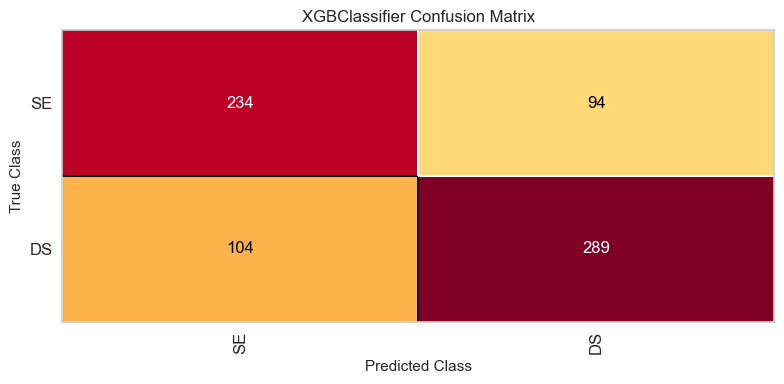

ConfusionMatrix(ax=<AxesSubplot: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=['SE', 'DS'],
                cmap=<matplotlib.colors.ListedColormap object at 0x29928e9b0>,
                estimator=XGBClassifier(alpha=0.19514909424102928,
                                        base_score=0.5, booster='gbtree',
                                        callbacks=None, colsample_bylevel=1,
                                        colsample_bynode=1,
                                        colsample_b...
                                        grow_policy='depthwise',
                                        importance_type=None,
                                        interaction_constraints='',
                                        lambda=0.010955985134796302,
                                        learning_rate=0.004570442245136879,
                                        max_bin=256, max_cat_threshold=64,
                                        max_cat_to_onehot=4, max_delta_step=0,
                                        max_depth=3, max_leaves=0,
                                        min_child_weight=0.2497193683952876,
                                        missing=nan, monotone_constraints='()',
                                        n_estimators=2000, n_jobs=0,
                                        num_parallel_tree=1, ...))

In [149]:
fig, ax = plt.subplots(figsize=(8,4))
classifier.confusion_matrix(xgb_hyp, kag_X_train, kag_y_train,
                            kag_X_test, kag_y_test,
                            classes=['SE', 'DS']
                           )

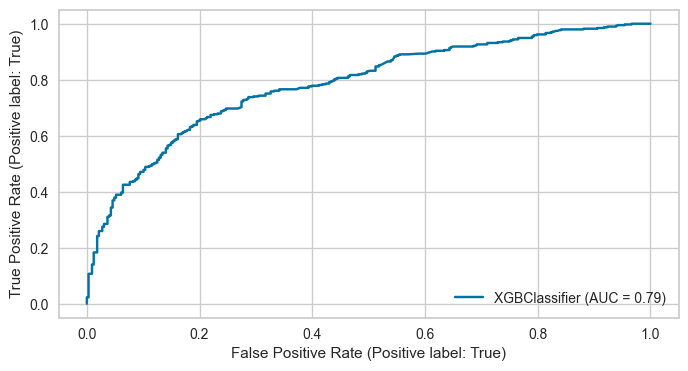

In [150]:
fig, ax = plt.subplots(figsize=(8,4))
metrics.RocCurveDisplay.from_estimator(xgb_hyp,
                       kag_X_test, kag_y_test,ax=ax)

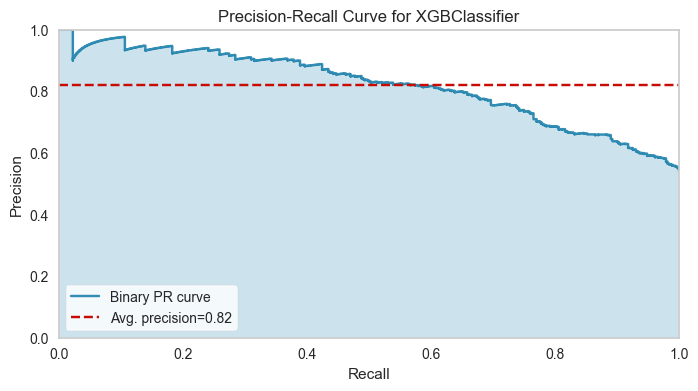

PrecisionRecallCurve(ax=<AxesSubplot: title={'center': 'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>,
                     classes=['SE', 'DS'],
                     estimator=XGBClassifier(alpha=0.19514909424102928,
                                             base_score=0.5, booster='gbtree',
                                             callbacks=None,
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=0.8227256149391048,
                                             early_stopping_rounds=None,
                                             e...
                                             interaction_constraints='',
                                             lambda=0.010955985134796302,
                                             learning_rate=0.004570442245136879,
                                             max_bin=256, max_cat_threshold=64,
                                             max_cat_to_onehot=4,
                                             max_delta_step=0, max_depth=3,
                                             max_leaves=0,
                                             min_child_weight=0.2497193683952876,
                                             missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=2000, n_jobs=0,
                                             num_parallel_tree=1, ...),
                     iso_f1_values={0.2, 0.4, 0.6, 0.8}, micro=False)

In [151]:
fig, ax = plt.subplots(figsize=(8,4))
classifier.precision_recall_curve(xgb_hyp, kag_X_train, kag_y_train,
                   kag_X_test, kag_y_test,
                   classes=['SE', 'DS'],
                   micro=False, macro=False
                   )

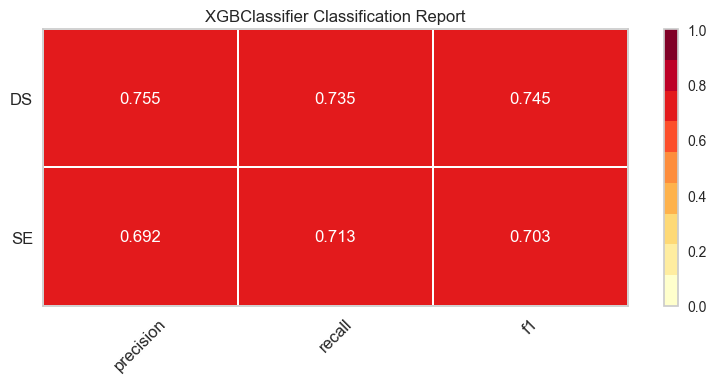

ClassificationReport(ax=<AxesSubplot: title={'center': 'XGBClassifier Classification Report'}>,
                     classes=['SE', 'DS'],
                     cmap=<matplotlib.colors.ListedColormap object at 0x285459b70>,
                     estimator=XGBClassifier(alpha=0.19514909424102928,
                                             base_score=0.5, booster='gbtree',
                                             callbacks=None,
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=0.8227256149391048,
                                             early_st...
                                             gpu_id=-1, grow_policy='depthwise',
                                             importance_type=None,
                                             interaction_constraints='',
                                             lambda=0.010955985134796302,
                                             learning_rate=0.004570442245136879,
                                             max_bin=256, max_cat_threshold=64,
                                             max_cat_to_onehot=4,
                                             max_delta_step=0, max_depth=3,
                                             max_leaves=0,
                                             min_child_weight=0.2497193683952876,
                                             missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=2000, n_jobs=0,
                                             num_parallel_tree=1, ...))

In [152]:
fig, ax = plt.subplots(figsize=(8,4))
classifier.classification_report(xgb_hyp, kag_X_train, kag_y_train,
                   kag_X_test, kag_y_test,
                   classes=['SE', 'DS'],
                   micro=False, macro=False
                   )

## Training For Different Metrics

We tuned our model. But we tuned it against accuracy. What if we want to optimize for recall?

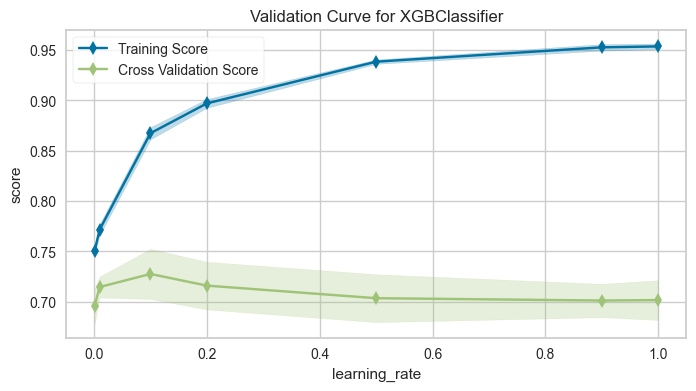

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]))

In [153]:
# accuracy tuning
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X_train, kag_y_train,
    #                param_name='max_depth', param_range=[1,2,5,10]
                    param_name='learning_rate', param_range=[0.001, .01, .1, .2, .5, .9, 1]
    )

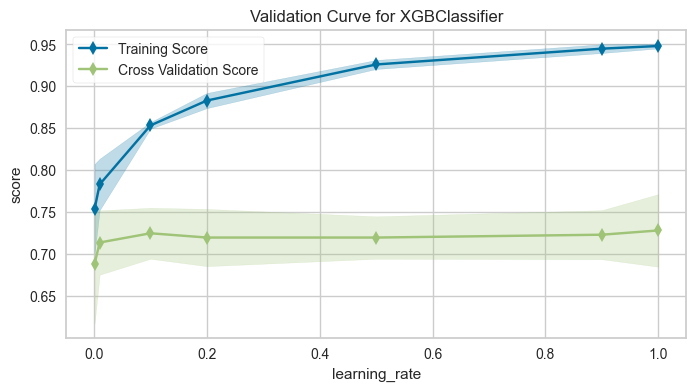

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]),
                scoring='recall')

In [154]:
# recall tuning
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X_train, kag_y_train,
                    scoring='recall',
                    #param_name='max_depth', param_range=[1,2,5,10]
                    param_name='learning_rate', param_range=[0.001, .01, .1, .2, .5, .9, 1]
                   )

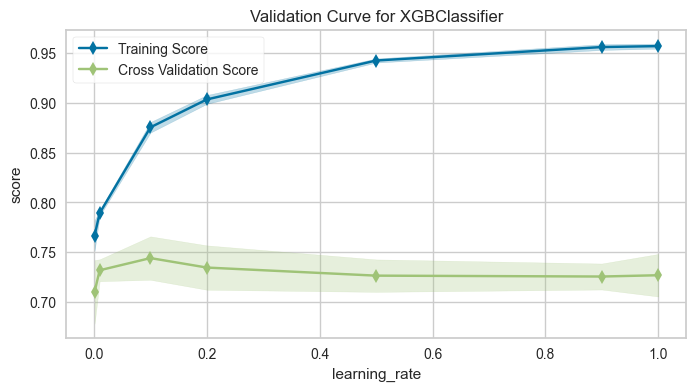

ValidationCurve(ax=<AxesSubplot: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='learning_rate', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, predictor=None,
                                        random_state=None, ...),
                param_name='learning_rate',
                param_range=array([0.001, 0.01 , 0.1  , 0.2  , 0.5  , 0.9  , 1.   ]),
                scoring='f1')

In [155]:
fig, ax = plt.subplots(figsize=(8,4))
ms.validation_curve(xgb.XGBClassifier(),
                    kag_X_train, kag_y_train,
                    scoring='f1',
                    #param_name='max_depth', param_range=[1,2,5,10]
                    param_name='learning_rate', param_range=[0.001, .01, .1, .2, .5, .9, 1]
                   )

## Model Interpretation

In [156]:
# Trees are great when they overfit... They can explain what they overfit
# (You can use these for "surrogate models")
hi_variance = tree.DecisionTreeClassifier(max_depth=None)
hi_variance.fit(kag_X_train, kag_y_train)
hi_variance.score(kag_X_test, kag_y_test)

0.6532593619972261

<AxesSubplot: >

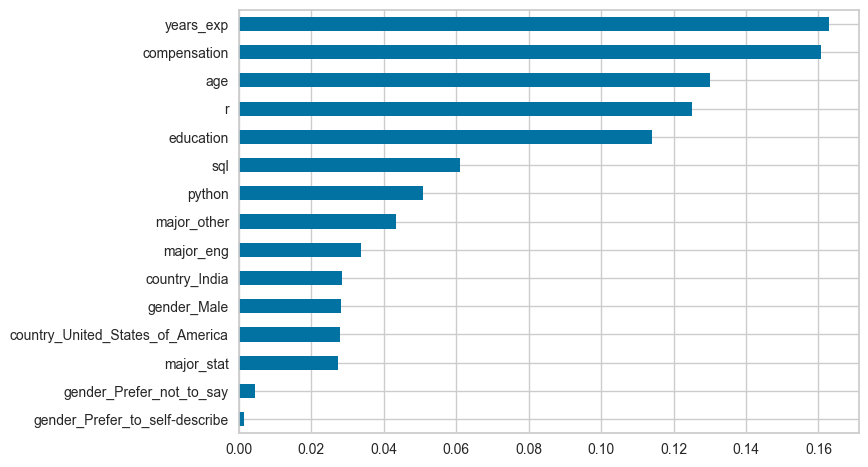

In [157]:
# Feature importance shows the magnitude (not direction) of impact
(pd.Series(hi_variance.feature_importances_, index=kag_X_train.columns)
 .sort_values()
 .plot.barh()
)

In [158]:
# XGBoost also supports feature importance
xgb_def = xgb.XGBClassifier()
xgb_def.fit(kag_X_train, kag_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot: >

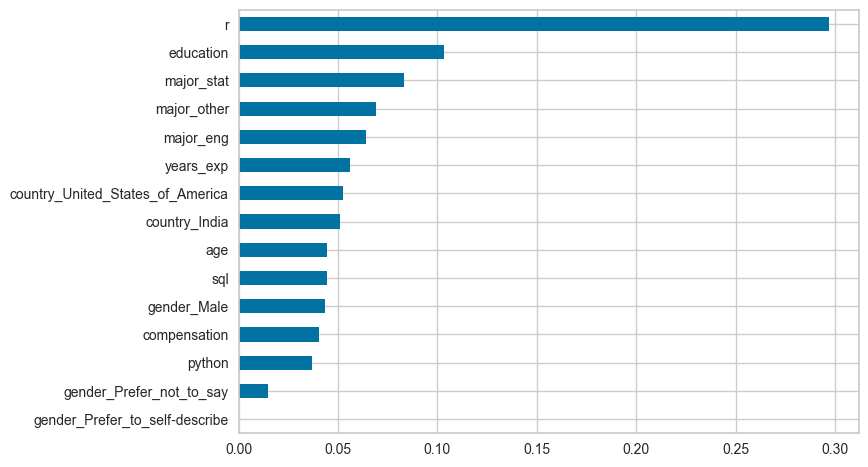

In [159]:
(pd.Series(xgb_def.feature_importances_, index=kag_X_train.columns)
 .sort_values()
 .plot.barh()
)

<AxesSubplot: >

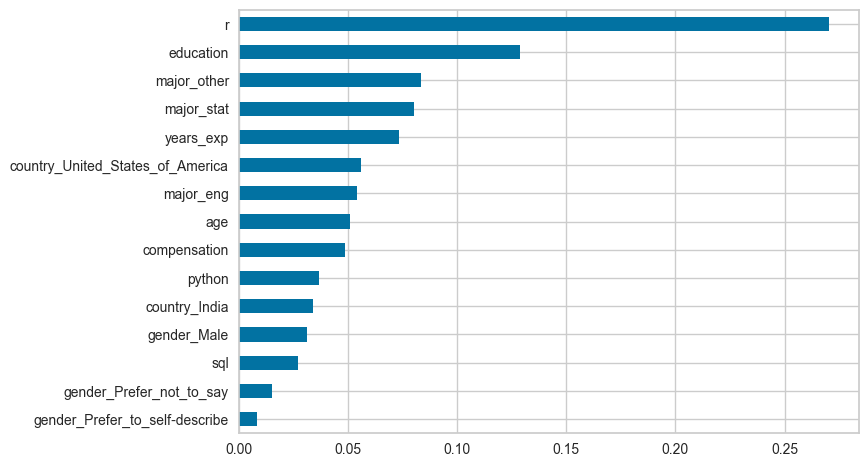

In [160]:
# Feature importance is specific to model/hyperparameters
(pd.Series(xgb_hyp.feature_importances_, index=kag_X_train.columns)
 .sort_values()
 .plot.barh()
)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

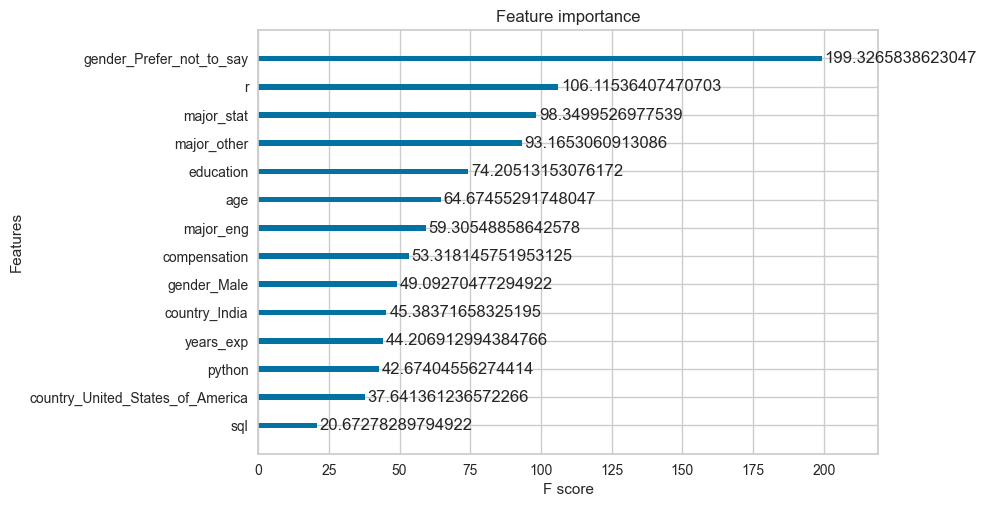

In [161]:
# * "weight" is the number of times a feature appears in a tree
# * "gain" is the average gain of splits which use the feature
# * "cover" is the average coverage of splits which use the feature
xgb.plot_importance(xgb_def, importance_type='cover')

## Bonus: xgbfir (Feature Interactions Reshaped)
 *Gain*: Total gain of each feature or feature interaction
 
 *FScore*: Amount of possible splits taken on a feature or feature Interaction
 
 *wFScore*: Amount of possible splits taken on a feature or feature nteraction weighted by the probability of the splits to take place
 
 *Average wFScore*: wFScore divided by FScore
 
 *Average Gain*: Gain divided by FScore
 
 *Expected Gain*: Total gain of each feature or feature interaction weighted by the probability to gather the gain


In [ ]:
!pip install openpyxl

In [ ]:
import xgbfir
xgbfir.saveXgbFI(xgb_def, feature_names=kag_X_train.columns, OutputXlsxFile='fir.xlsx')
pd.read_excel('fir.xlsx')

In [ ]:
pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 1')

In [ ]:
pd.read_excel('fir.xlsx', sheet_name='Interaction Depth 2')

# SHAP (SHapley Additive exPlantations)
Should be *globally* consistent and accurate

 Shapley value (SHAP).
 
 From game theory, indicates how to distribute attribution of label



In [163]:
import shap
shap.initjs()

# make sure you initialize the js side
shap_ex = shap.TreeExplainer(xgb_def)
vals = shap_ex(kag_X_test)

In [164]:
vals

.values =
array([[-7.3671937e-02, -5.2863276e-03,  0.0000000e+00, ...,
         2.0145360e-01, -5.3606921e-01, -1.7650269e-01],
       [ 1.1465865e+00, -5.0477749e-03,  0.0000000e+00, ...,
         2.1595242e-02,  2.0478895e+00, -4.2374185e-03],
       [-5.9070452e-03, -6.7503033e-03,  0.0000000e+00, ...,
         3.8105714e-01, -7.1735996e-01, -2.4497770e-02],
       ...,
       [ 1.2569400e-03, -7.2259433e-03,  0.0000000e+00, ...,
        -6.9848515e-02, -3.2383648e-01, -6.7913942e-02],
       [-3.5935082e-02, -7.1059922e-03,  0.0000000e+00, ...,
         6.6526450e-02, -6.6452891e-01, -7.2517872e-02],
       [ 5.7277378e-02, -5.5689747e-03,  0.0000000e+00, ...,
         1.6226484e-01, -4.0991175e-01,  5.1057201e-02]], dtype=float32)

.base_values =
array([0.2392328, 0.2392328, 0.2392328, 0.2392328, 0.2392328, 0.2392328,
       0.2392328, 0.2392328, 0.2392328, 0.2392328, 0.2392328, 0.2392328,
       0.2392328, 0.2392328, 0.2392328, 0.2392328, 0.2392328, 0.2392328,
       0.2392328, 0

In [165]:
# Let's explain an individual
kag_X_test.iloc[0]

gender_Male                             1.0
gender_Prefer_not_to_say                0.0
gender_Prefer_to_self-describe          0.0
age                                    30.0
country_India                           0.0
country_United_States_of_America        0.0
education                              16.0
major_eng                               0.0
major_other                             0.0
major_stat                              0.0
years_exp                               5.0
compensation                        50000.0
python                                  1.0
r                                       0.0
sql                                     0.0
Name: 173, dtype: float64

In [166]:
xgb_def.predict(kag_X_test.iloc[[0]])  # predicts SE... why?

array([0])

In [167]:
# label is also SE
kag_y_test.iloc[0]

False

In [168]:
# the base value. We sum up the scores.
# > 0 Positive Case
shap_ex.expected_value

0.2392328

In [169]:
# < 0 therefore ... SE
shap_ex.expected_value + vals.values[0].sum()

-3.2573564

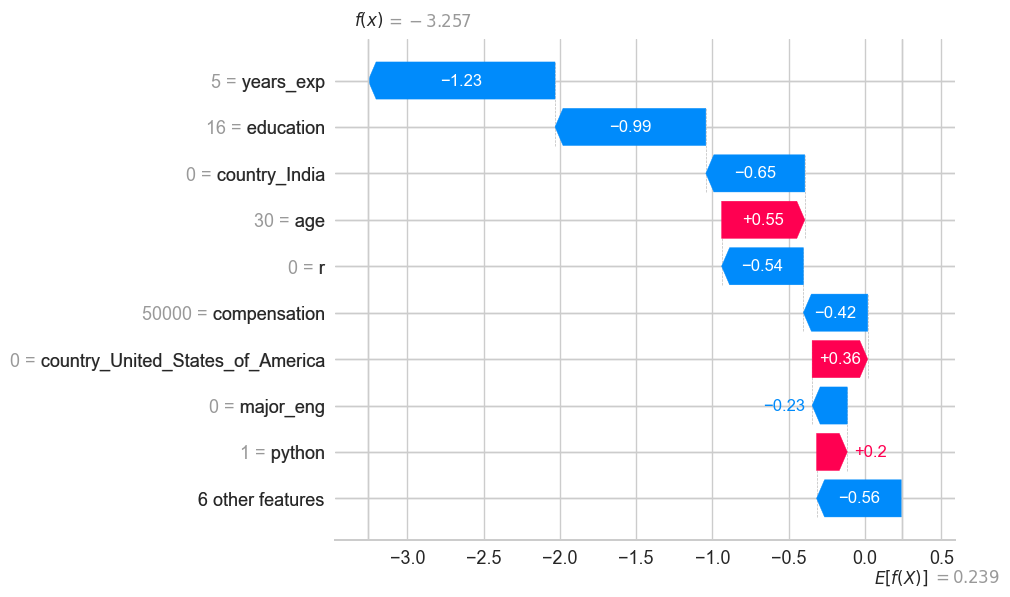

In [170]:
# blue - SE
# red - DS

shap.initjs()
shap.plots.waterfall(vals[0])

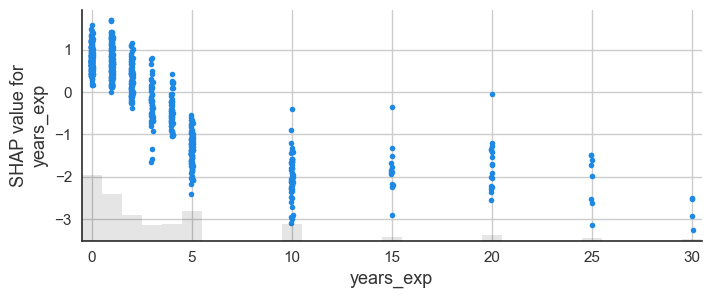

In [171]:
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'years_exp'], ax=ax)

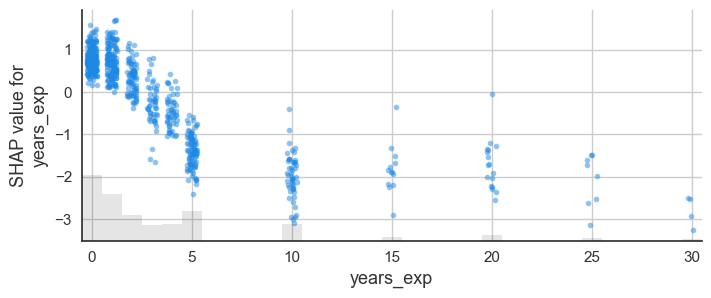

In [172]:
# with jitter/alpha
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'years_exp'], ax=ax, x_jitter=.5, alpha=.5)

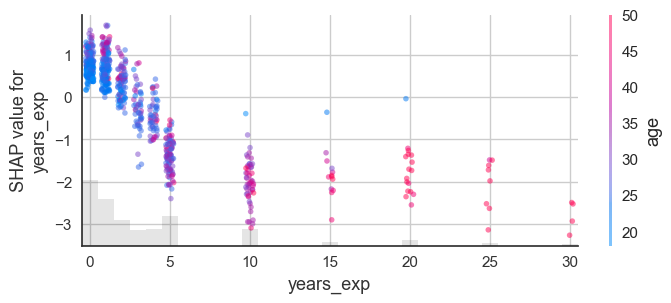

In [173]:
# add interaction (color)
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'years_exp'], color=vals, ax=ax, x_jitter=.5, alpha=.5)

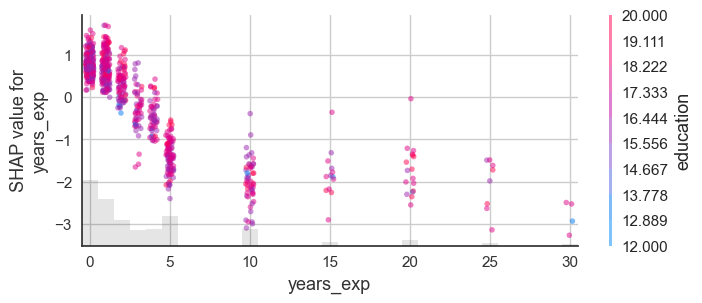

In [174]:
# specify interaction
fig, ax = plt.subplots(figsize=(8,3))
shap.plots.scatter(vals[:,'years_exp'], color=vals[:, 'education'], ax=ax, x_jitter=.5, alpha=.5)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


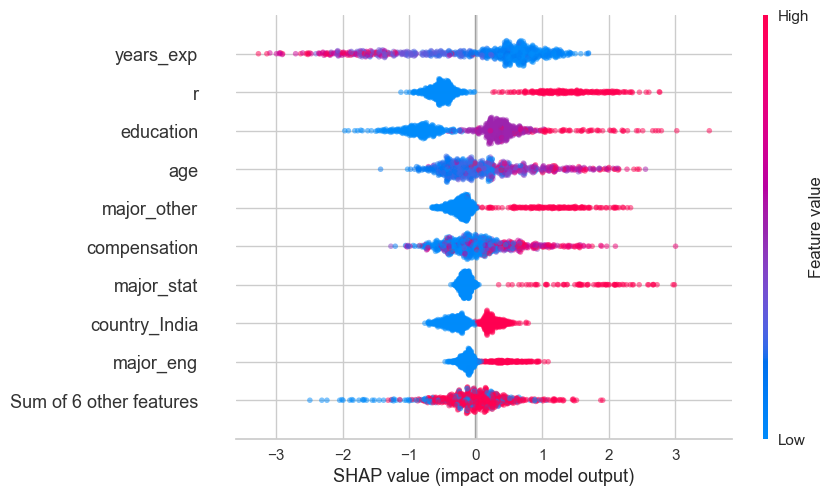

In [175]:
shap.plots.beeswarm(vals, alpha=.5)

# Summary

XGBoost is very powerful. Combining with other tools will take you a long way.

Explore your data and your results.

Lots of libraries. Some are better integrated.

Suggestions:

* Pandas skills come in useful for manipulating data
* Make sure you discuss business value with stake holders


Questions?


Connect on LinkedIn or Twitter `@__mharrison__`

In [ ]:
import random
random.randrange(1,9)

In [ ]:
random.randrange(1,5)